<b> Testing Open3D for Depth rendering </b>

In [4]:
import open3d as o3d
import cv2
from PIL import Image
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

### <b> Point Cloud (.ply) to 2D top down image (.png) </b>

In [2]:
#point_cloud = o3d.io.read_point_cloud("../../ply/raw/flexx2_pointcloud_50GA1_2024-09-12T18_23_11Z.ply")
#o3d.visualization.draw_geometries([point_cloud])

In [3]:
'''
print(f"Number of points: {len(point_cloud.points)}")
print(f"Has colors: {point_cloud.has_colors()}")
print(f"Has normals: {point_cloud.has_normals()}")


o3d.visualization.draw_geometries(
    [point_cloud],
    window_name="Point Cloud Visualization",
    width=800,
    height=600,
    left=50,
    top=50,
    point_show_normal=True 
)
'''

'\nprint(f"Number of points: {len(point_cloud.points)}")\nprint(f"Has colors: {point_cloud.has_colors()}")\nprint(f"Has normals: {point_cloud.has_normals()}")\n\n\no3d.visualization.draw_geometries(\n    [point_cloud],\n    window_name="Point Cloud Visualization",\n    width=800,\n    height=600,\n    left=50,\n    top=50,\n    point_show_normal=True \n)\n'

In [4]:
def pointcloud_to_image_cv2(pcd, width=1456, height=1092):
    """
    Convert point cloud file to top-down 2D depth image
    """
    points = np.asarray(pcd.points)
    
    # Check if point cloud is empty
    if len(points) == 0:
        return np.zeros((height, width), dtype=np.float32)
    
    # Get bounds
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    
    # Check for degenerate bounds
    if x_min == x_max or y_min == y_max:
        return np.zeros((height, width), dtype=np.float32)
    
    # Convert to pixel coordinates
    u = ((points[:, 0] - x_min) / (x_max - x_min) * (width - 1)).astype(int)
    v = ((points[:, 1] - y_min) / (y_max - y_min) * (height - 1)).astype(int)
    
    # Always create single-channel depth image
    image = np.zeros((height, width), dtype=np.float32)
    for i in range(len(u)):
        cv2.circle(image, (u[i], v[i]), 1, float(points[i, 2]), -1)
    
    return image

In [5]:
#point_cloud = o3d.io.read_point_cloud("../../ply/raw/flexx2_pointcloud_75GA2_2024-09-20T8_52_12Z.ply")
#o3d.visualization.draw_geometries([point_cloud])
#im_75GA2 = pointcloud_to_image_cv2(point_cloud)
#cv2.imwrite("pointcloud_topdown.png", im_75GA2)

In [6]:
point_clouds_dir = "../../ply/raw/"

In [7]:
def convert_all_ply(point_cloud_directory):

    point_clouds = os.listdir(point_cloud_directory)
    depth_png_directory = "../../Depth_INESC/"
    print(f"Total number of point clouds {len(point_clouds)}\n")
    
    if not os.path.exists(depth_png_directory):
        os.makedirs(depth_png_directory)

    for idx, p_cloud in enumerate(point_clouds):
        
        new_file_name = p_cloud[18:34] + '.png'
        save_here = depth_png_directory + new_file_name
        
        point_cloud = o3d.io.read_point_cloud(point_cloud_directory + p_cloud)
        two_d_png = pointcloud_to_image_cv2(point_cloud)
        
        # Convert depth to millimeters and save as 16-bit (preserve spatial information)
        depth_mm = (two_d_png * 1000).astype(np.uint16)
        cv2.imwrite(save_here, depth_mm)
        
        print(f"Point cloud {idx}/{len(point_clouds)-1} converted")

    print(f"2D top-down depth visualizations created and saved at {depth_png_directory}.")

In [8]:
convert_all_ply(point_cloud_directory=point_clouds_dir)

Total number of point clouds 448

Point cloud 0/447 converted
Point cloud 1/447 converted
Point cloud 2/447 converted
Point cloud 3/447 converted
Point cloud 4/447 converted
Point cloud 5/447 converted
Point cloud 6/447 converted
Point cloud 7/447 converted
Point cloud 8/447 converted
Point cloud 9/447 converted
Point cloud 10/447 converted
Point cloud 11/447 converted
Point cloud 12/447 converted
Point cloud 13/447 converted
Point cloud 14/447 converted
Point cloud 15/447 converted
Point cloud 16/447 converted
Point cloud 17/447 converted
Point cloud 18/447 converted
Point cloud 19/447 converted
Point cloud 20/447 converted
Point cloud 21/447 converted
Point cloud 22/447 converted
Point cloud 23/447 converted
Point cloud 24/447 converted
Point cloud 25/447 converted
Point cloud 26/447 converted
Point cloud 27/447 converted
Point cloud 28/447 converted
Point cloud 29/447 converted
Point cloud 30/447 converted
Point cloud 31/447 converted
Point cloud 32/447 converted
Point cloud 33/447 

In [9]:
depth_png_directory = "../../Depth_INESC/"
print(f"Directory exists: {os.path.exists(depth_png_directory)}")
print(f"Full path: {os.path.abspath(depth_png_directory)}")

Directory exists: True
Full path: /Users/rodrigocastro/Desktop/lettuceimagepreds/Depth_INESC


In [10]:
#rgb_image = Image.open("../../NewRGBImages/images_with_gt/50GA1_2024-09-07.png")
#rgb_width, rgb_height = rgb_image.size
#print(f"Width: {rgb_width} px | Height: {rgb_height} px")

In [11]:
depth_path = "../../Depth_INESC/50GA1_2024-09-12.png"
depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
depth_tensor = torch.from_numpy(depth).float()  # (H, W)
depth_tensor = depth_tensor.unsqueeze(0)
print(type(depth_tensor))
print(f"Max. value: {torch.max(depth_tensor)}| Min. value: {torch.min(depth_tensor)}")


<class 'torch.Tensor'>
Max. value: 502.0| Min. value: 0.0


In [12]:
depth_tensor.shape

torch.Size([1, 1092, 1456])

### <b> Check distance to camera distribution for depth images </b>

In [2]:
def depth_values_frequency_histogram(depth_path):

    images = [f for f in os.listdir(depth_path)]
    print(f"Images: {images}")
    num_images = len(images)
    print(num_images)
    height, width = 1092, 1456 # CHECK IF THIS IS CORRECT (or the other way around)
    all_values = np.zeros((num_images * height * width,), dtype=np.uint16)

    print(f"Preallocated shape: {all_values.shape}")

    idx = 0 # For smart allocation
    for i,img in enumerate(images):
        img_path = os.path.join(depth_path, img)

        # Read raw depth image with original bit-depth (likely uint16)
        depth_raw = cv2.imread(depth_path+'/'+img, cv2.IMREAD_UNCHANGED)

        if depth_raw is None:
            print(f"Warning: Failed to load {depth_path+'/'+img}")
            continue

        print(f"({i}/{num_images-1}) Reading {img_path} | dtype: {depth_raw.dtype} | shape: {depth_raw.shape}")

        # Flatten and append raw values
        flat = depth_raw.flatten()
        all_values[idx:idx + flat.size] = flat
        idx += flat.size
    
    # Plot histogram
    plt.hist(all_values, bins=100)
    plt.title("Raw Depth Value Distribution (All Images)")
    plt.xlabel("Depth Value")
    plt.ylabel("Count")
    plt.show()

Images: ['75GB3_2024-09-17.png', '75RA5_2024-09-23.png', '75RA2_2024-09-20.png', '75RB1_2024-09-13.png', '75RC4_2024-09-13.png', '75GC1_2024-09-14.png', '75GB4_2024-09-14.png', '75RC2_2024-09-14.png', '75GB2_2024-09-13.png', '75GA1_2024-09-20.png', '75RA3_2024-09-24.png', '50GB5_2024-09-25.png', '75RA3_2024-09-18.png', '75RC5_2024-09-17.png', '75RC5_2024-09-16.png', '50GB5_2024-09-24.png', '50GB5_2024-09-18.png', '75RA3_2024-09-25.png', '75GB2_2024-09-12.png', '50GA1_2024-09-14.png', '75RC4_2024-09-12.png', '75RB1_2024-09-12.png', '50GC1_2024-09-20.png', '50GB4_2024-09-20.png', '50GB3_2024-09-23.png', '75GB3_2024-09-16.png', '75GB3_2024-09-14.png', '75RC3_2024-09-13.png', '75RA5_2024-09-20.png', '75RA2_2024-09-23.png', '75GC1_2024-09-17.png', '75GB4_2024-09-17.png', '75RC2_2024-09-17.png', '50GA1_2024-09-16.png', '75RA4_2024-09-18.png', '50GB2_2024-09-25.png', '75GA1_2024-09-23.png', '75RA4_2024-09-24.png', '75GB5_2024-09-13.png', '75RC5_2024-09-14.png', '75GB5_2024-09-12.png', '75RA4_

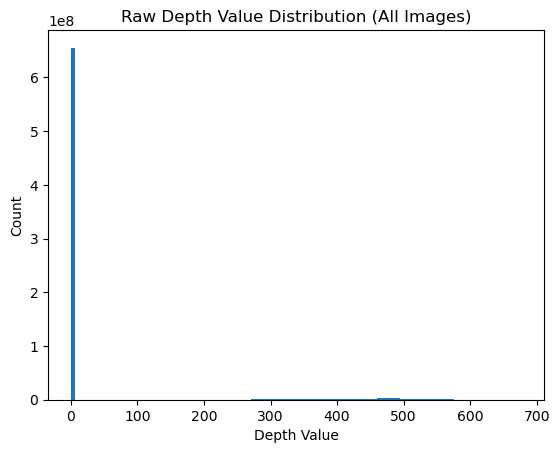

In [5]:
depth_values_frequency_histogram(depth_path= "../../Depth_INESC/")

#### <b> O que preciso:</b>

* Sistema de coordenadas: Assegura-me de que a point cloud está no mesmo sistema de coordenadas do que a câmara
* Calibração da câmara: Usar os parâmetros de calibração da câmara (comprimento focal x e y, altura a que a câmara estava durante a experiência) -> Para projeções 3D p/ 2D: <b> DATA SHEET: através da dist focal e souber a área super da alface e comparar com lidar 3d obtenho o fator de escala p/ conversão do sist de coordenadas (consigo inferir altura) </b>
* Escala de Profundidate/Depth: Qual é a escala em milímetros? <b> METROS </b>
* Transformação de sistema de coordenadas LiDAR -> Câmara